In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [16]:
BASE_DIRECTORY = "AI Students Picture"



def process_data():
    image_data = []
    targets = []
    names = {}

    for i, folder in enumerate(os.listdir(BASE_DIRECTORY)):
        folder_path = os.path.join(BASE_DIRECTORY, folder)
        names[i] = folder
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            # print(f"Attempting to open: {image_path}")
            try:
                with Image.open(image_path) as img:
                    img = img.resize((150, 150))
                    img = img.convert("L")
                    img_array = np.array(img)
                    image_data.append(img_array)
                    targets.append(i)
            except Exception as e:
                print(f"Error opening {image_path}: {e}")
    print(image_data)
    image_data = np.array(image_data)
    print(image_data.shape)
    targets = np.array(targets)
    print(names)
    train_data, test_data, train_label, test_label = [], [], [], []

    for person in range(51):
        person_indices = np.where(targets == person)[0]
        train_indices = person_indices[3: 11]
        test_indices = person_indices[:3]
        train_data.extend(image_data[train_indices])
        train_label.extend(targets[train_indices])
        test_data.extend(image_data[test_indices])
        test_label.extend(targets[test_indices])
    
    train_data = np.array(train_data)
    train_label = np.array(train_label)
    test_data = np.array(test_data)
    test_label = np.array(test_label)
    
    return train_data, train_label, test_data, test_label, names

train_data, train_label, test_data, test_label, names = process_data()
print(names)

print("Training Data set", train_data,"\n, Training Labels", train_label)

print("Testing Data set", test_data, "\n, Testing Labels", test_label)


[array([[252, 252, 252, ..., 248, 248, 248],
       [252, 252, 252, ..., 248, 248, 248],
       [252, 252, 252, ..., 248, 248, 248],
       ...,
       [133, 132, 114, ...,  94, 113, 109],
       [112, 128, 130, ..., 107, 114, 102],
       [108, 110, 129, ..., 111, 110,  96]], dtype=uint8), array([[253, 253, 253, ..., 248, 249, 247],
       [253, 253, 253, ..., 250, 249, 248],
       [253, 252, 252, ..., 250, 248, 248],
       ...,
       [149, 140, 136, ...,  38,  36,  27],
       [138, 143, 141, ...,  36,  32,  27],
       [125, 132, 139, ...,  35,  30,  38]], dtype=uint8), array([[254, 254, 254, ..., 251, 251, 251],
       [254, 254, 254, ..., 251, 251, 251],
       [254, 254, 254, ..., 251, 251, 251],
       ...,
       [102,  88,  70, ...,  43,  43,  43],
       [121, 134, 124, ...,  43,  44,  43],
       [104, 124, 136, ...,  41,  43,  42]], dtype=uint8), array([[253, 253, 253, ..., 252, 250, 251],
       [253, 253, 253, ..., 251, 251, 250],
       [253, 253, 253, ..., 250, 250, 

The Data set is now divided into Training data set and  Testing Data set with their corresponding label or class.

In [5]:
def EuclideanDistance(p, q):
        p = np.asarray(p).flatten()
        q = np.asarray(q).flatten()
        return np.sqrt(np.sum(np.power((p - q), 2)))

In [6]:
  
def project( W, train_data, mu = None):
        if mu is None:
            return np.dot(train_data, W)
        return np.dot(train_data - mu, W)
    
def reconstruct( W, Y, mu = None):
        if mu is None:
            return np.dot(Y, W.T)
        return np.dot(Y, W.T) + mu
    
def pca( train_data, train_label, num_components = 0):
        [n, d] = train_data.shape

        if (num_components <= 0) or (num_components > n):
            num_components = n
        
        mu = train_data.mean(axis = 0)
        train_data = train_data - mu

        if n > d:
             C= np.dot(train_data.T, train_data)
             [eigenvalues, eigenvectors] = np.linalg.eigh(C)
        else:
            C = np.dot(train_data, train_data.T)
            [eigenvalues, eigenvectors] = np.linalg.eigh(C)
            eigenvectors = np.dot(train_data.T, eigenvectors)

            for i in range(n):
                eigenvectors[:, i] = eigenvectors[:, i] / np.linalg.norm(eigenvectors[:, i])
            
        idx = np.argsort(-eigenvalues)
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        eigenvalues = eigenvalues[0: num_components].copy()
        eigenvectors = eigenvectors[:, 0: num_components].copy()

        return [eigenvalues, eigenvectors, mu]
    
def lda( train_data, train_label, num_components = 0):
        [n,d] = train_data.shape

        c = np.unique(train_label)

        if (num_components <= 0) or (num_components > (len(c) - 1)):
            num_components = len(c) - 1
        
        meanTotal = train_data.mean(axis = 0)

        Sw = np.zeros((d, d), dtype = np.float32)
        Sb = np.zeros((d, d), dtype = np.float32)

        for i in c:
            train_datai = train_data[np.where(train_label == i)[0], :]
            meanClass = train_datai.mean(axis = 0)
            Sw = Sw + np.dot((train_datai - meanClass).T, (train_datai - meanClass))
            Sb = Sb + n * np.dot((meanClass - meanTotal), (meanClass - meanTotal).T)

        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(Sw) * Sb)
        idx = np.argsort(-eigenvalues.real)

        eigenvalues, eigenvectors = eigenvalues[idx], eigenvectors[:, idx]

        eigenvalues = np.array(
            eigenvalues[0: num_components].real, dtype = np.float32, copy = True
        )

        eigenvectors = np.array(
            eigenvectors[0:, 0:num_components].real, dtype = np.float32, copy = True
        )

        return [eigenvalues, eigenvectors]
    
def fisherfaces( train_data,train_label, num_components = 0):

        n = train_data.shape[0]

        c = len(np.unique(train_label))
        [eigenvalues_pca, eigenvectors_pca, mu_pca] = pca(train_data, train_label, n - c)

        [eigenvalues_lda, eigenvectors_lda] = lda(project(eigenvectors_pca, train_data, mu_pca), train_label, num_components)

        eigenvectors = np.dot(eigenvectors_pca, eigenvectors_lda)

        return [eigenvalues_lda, eigenvectors, mu_pca]
    
def create_font( fontname = "Arial", fontsize = 10):
        return {"fontname": fontname, "fontsize": fontsize}
    
def normalize( x, low, high, dtype = None):
        minx, marx = np.min(x), np.max(x)

        x = x - float(minx)
        x = x / float((marx - minx))
        x = x * (high - low)
        x = x + low

        if dtype is None:
            return np.asarray(x)
        return np.asarray(x, dtype = None)
    
def asRowMatrix( X):
        if len(X) == 0:
            return np.array([])
        mat = np.empty((0,X[0].size), dtype = X[0].dtype)

        for row in X:
            mat = np.vstack((mat, np.asarray(row).reshape(1, -1)))
        
        return mat
def subplot(
            title,
            images,
            rows,
            cols,
            sptitle = "subplot",
            sptitles = [], 
            colormap = cm.gray,
            ticks_visible = True,
            filename = None
    ):
        fig = plt.figure()
        fig.text(0.5, 0.95,title, horizontalalignment = "center")
        
        for i in range(len(images)):
            ax0 = fig.add_subplot(rows, cols, (i + 1))
            plt.setp(ax0.get_xticklabels(), visible = False)
            plt.setp(ax0.get_yticklabels(), visible = False)

            if len(sptitles) == len(images):
                plt.title(
                    "%s #%s" % (sptitle, str(sptitles[i])),
                    create_font("Tahoma", 10),
                ) 
            else:
                plt.title("%s #%d" % (sptitle, (i + 1)), create_font("Tahoma",10))
            plt.imshow(np.asarray(images[i]), cmap = colormap)
        
        if filename is None:
            plt.show()
        
        else:
            fig.savefig(filename)
                   

The reconstructed images are as Follow.

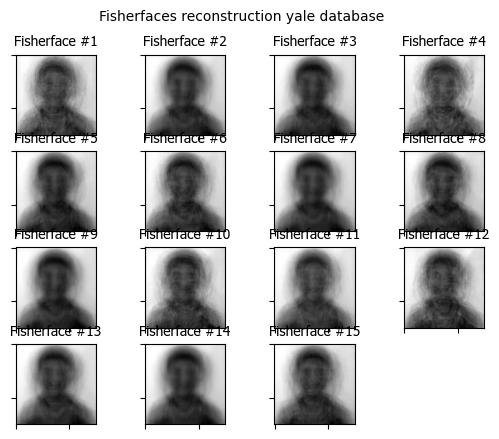

(22500,) original
True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True

In [35]:
[D, W, mu] = fisherfaces(asRowMatrix(train_data), train_label)

E = []

for i in range(min(W.shape[1], 15)):
    e = W[:, i].reshape(-1, 1)
    p = project(e, train_data[0].reshape(1, -1), mu)
    R = reconstruct(e, p, mu)
    R = R.reshape(train_data[0].shape)
    E.append(normalize(R, 0, 255))

subplot(
    title = "Fisherfaces reconstruction yale database",
    images = E,
    rows = 4,
    cols = 4,
    sptitle = "Fisherface",
    colormap = cm.gray,
)


import h5py


# # On the source machine


# with h5py.File('model.h5', 'w') as file:
#     file.create_dataset('D', data=D)
#     file.create_dataset('W', data=W)
#     file.create_dataset('mu', data = mu)
#     file.create_dataset('train_label', data = train_label)
    # file.create_dataset('names', data = np.string_(names))

# On the destination machine
print(mu.shape,"original")
with h5py.File("model.h5", "r") as file:
            Dz = file["D"][:]
            Wz = file["W"][:]
            muz = file["mu"][:]
            train_labelz = file["train_label"][:]
            

print(muz.shape == mu.shape)
print(D == Dz)
print(Wz == W)
print(train_labelz == train_label)

Now We can proceed to predicting function.

In [36]:
def compute(X, y):
    projections = []
    data_matrix = []
    [D, W, mu]  = fisherfaces(asRowMatrix(X), y, num_components = 0)
    for xi in X:
        projections.append(project(W, xi.reshape(1, -1), mu))
        data_matrix.append(xi)
    return projections, data_matrix

def predict(test_data):
    projections, data = compute(train_data, train_label)
    # print("here is the projections", projections)
    
    minDist = np.finfo("float").max
    minClass = -1

    Q = project(W, test_data.reshape(1, -1), mu)
    res = []
    for i in range(len(projections)):
        dist = EuclideanDistance(projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = train_label[i]
            res = data[i]
    return minClass, res

projection, data_matrix = compute(train_data, train_label)
# print(projection)
# print("======================================:")
# print(data_matrix)

# with h5py.File('model.h5', 'w') as file:
#     file.create_dataset('D', data=D)
#     file.create_dataset('W', data=W)
#     file.create_dataset('mu', data = mu)
#     file.create_dataset('train_label', data = train_label)
#     file.create_dataset('projection', data = projection)



In [32]:
test_arr = []
with Image.open("fasika.jpg") as img:
                    img = img.resize((150, 150))
                    img = img.convert("L")
                    img_array = np.array(img)
                    test_arr.append(img_array)
with Image.open("ephi.jpg") as img:
                    img = img.resize((150, 150))
                    img = img.convert("L")
                    img_array = np.array(img)
                    test_arr.append(img_array)
with Image.open("output.png") as img:
                    img = img.resize((150, 150))
                    img = img.convert("L")
                    img_array = np.array(img)
                    test_arr.append(img_array)
with Image.open("dagi1.jpg") as img:
                    img = img.resize((150, 150))
                    img = img.convert("L")
                    img_array = np.array(img)
                    test_arr.append(img_array)
# print(test_arr[0])

In [34]:
E = []
for index, test in enumerate(test_arr):
    a, data = predict(test_arr[index])
    # print(data)
    # plt.imshow(data, cmap='gray')  # 'gray' colormap for grayscale images
    # plt.title(names[a])
    # plt.show()
    print(names[a])
    # print("Expected = ", test_label[index], " /predicted = ", predict(test_data[index]))

subplot(
    title = "Fisherfaces reconstruction yale database",
    images = E,
    rows = 4,
    cols = 4,
    sptitle = "Fisherface",
    colormap = cm.gray,
)

Fasika_Fikadu
Ephrem_Shimels
Biniyam Haile
Dagmawi_Tensay


<Figure size 640x480 with 0 Axes>

Here we will predict the labels for the test data and calculate the performance of fisherface.

In [27]:
corrects = 0
total = 0
for index, test in enumerate(test_data):
    total += 1
    if test_label[index] == predict(test_data[index]):
        corrects += 1
    print("Expected = ", test_label[index], " /predicted = ", predict(test_data[index]))


print(f"The algorithm's accuracy is {(corrects / total) * 100}%")

Expected =  0  /predicted =  0
Expected =  0  /predicted =  0
Expected =  0  /predicted =  0
Expected =  1  /predicted =  1
Expected =  1  /predicted =  1
Expected =  1  /predicted =  1
Expected =  2  /predicted =  2
Expected =  2  /predicted =  2
Expected =  2  /predicted =  2
Expected =  3  /predicted =  3
Expected =  3  /predicted =  3
Expected =  3  /predicted =  3
Expected =  4  /predicted =  4
Expected =  4  /predicted =  4
Expected =  4  /predicted =  4
Expected =  5  /predicted =  5
Expected =  5  /predicted =  5
Expected =  5  /predicted =  5
Expected =  6  /predicted =  6
Expected =  6  /predicted =  6
Expected =  6  /predicted =  6
Expected =  7  /predicted =  7
Expected =  7  /predicted =  7
Expected =  7  /predicted =  7
Expected =  8  /predicted =  8
Expected =  8  /predicted =  8
Expected =  8  /predicted =  8
Expected =  9  /predicted =  9
Expected =  9  /predicted =  9
Expected =  9  /predicted =  9
Expected =  10  /predicted =  10
Expected =  10  /predicted =  39
Expe

In [23]:
[D, W, mu] = fisherfaces(asRowMatrix(train_data), train_label)
file_path = "fisherfaces.txt"

# Writing to the file
with open(file_path, "w") as file:
    file.write(str(D) + '\n')
    file.write(str(W) + '\n')
    file.write(str(mu) + '\n')

# Reading from the file


# Converting the read strings back to arrays


# Reshape the arrays if needed
# D = D.reshape((D.shape[0],))
# W = W.reshape((W.shape[0], -1))
# mu = mu.reshape((mu.shape[0],))

# Now D, W, and mu contain the loaded values
# print(D)
# print(W)

In [27]:
with open(file_path, "r") as file:
    D_str = file.readline().strip()
    W_str = file.readline().strip()
    mu_str = file.readline().strip()

D = np.fromstring(D_str[1:-1], sep=' ')
W = np.fromstring(W_str[1:-1], sep=' ')
mu = np.fromstring(mu_str[1:-1], sep=' ')

print(D)

[7.47121733e+21 1.61080628e+21 9.34751165e+20 6.94801277e+02]
